In [1]:
import pandas as pd
import numpy as np
import os, zipfile
import subprocess

In [2]:
from imblearn.combine import SMOTEENN

In [3]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

In [29]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgbm
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

In [6]:
import category_encoders as ce

In [5]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 200

In [60]:
dir_name = 'D:\\1mfti\ml\Home-Credit-Default-Risk'
extension = ".zip"

os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [61]:
train = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')

EDA

In [56]:
train.shape

(307511, 122)

In [62]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [52]:
train_norm.shape

(307511, 122)

In [12]:
train.info(verbose=True,  show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [13]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [12]:
train.describe(include = 'object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


array([[<AxesSubplot:title={'center':'SK_ID_CURR'}>,
        <AxesSubplot:title={'center':'TARGET'}>,
        <AxesSubplot:title={'center':'CNT_CHILDREN'}>,
        <AxesSubplot:title={'center':'AMT_INCOME_TOTAL'}>,
        <AxesSubplot:title={'center':'AMT_CREDIT'}>,
        <AxesSubplot:title={'center':'AMT_ANNUITY'}>,
        <AxesSubplot:title={'center':'AMT_GOODS_PRICE'}>,
        <AxesSubplot:title={'center':'REGION_POPULATION_RELATIVE'}>,
        <AxesSubplot:title={'center':'DAYS_BIRTH'}>,
        <AxesSubplot:title={'center':'DAYS_EMPLOYED'}>],
       [<AxesSubplot:title={'center':'DAYS_REGISTRATION'}>,
        <AxesSubplot:title={'center':'DAYS_ID_PUBLISH'}>,
        <AxesSubplot:title={'center':'OWN_CAR_AGE'}>,
        <AxesSubplot:title={'center':'FLAG_MOBIL'}>,
        <AxesSubplot:title={'center':'FLAG_EMP_PHONE'}>,
        <AxesSubplot:title={'center':'FLAG_WORK_PHONE'}>,
        <AxesSubplot:title={'center':'FLAG_CONT_MOBILE'}>,
        <AxesSubplot:title={'center':'FLA

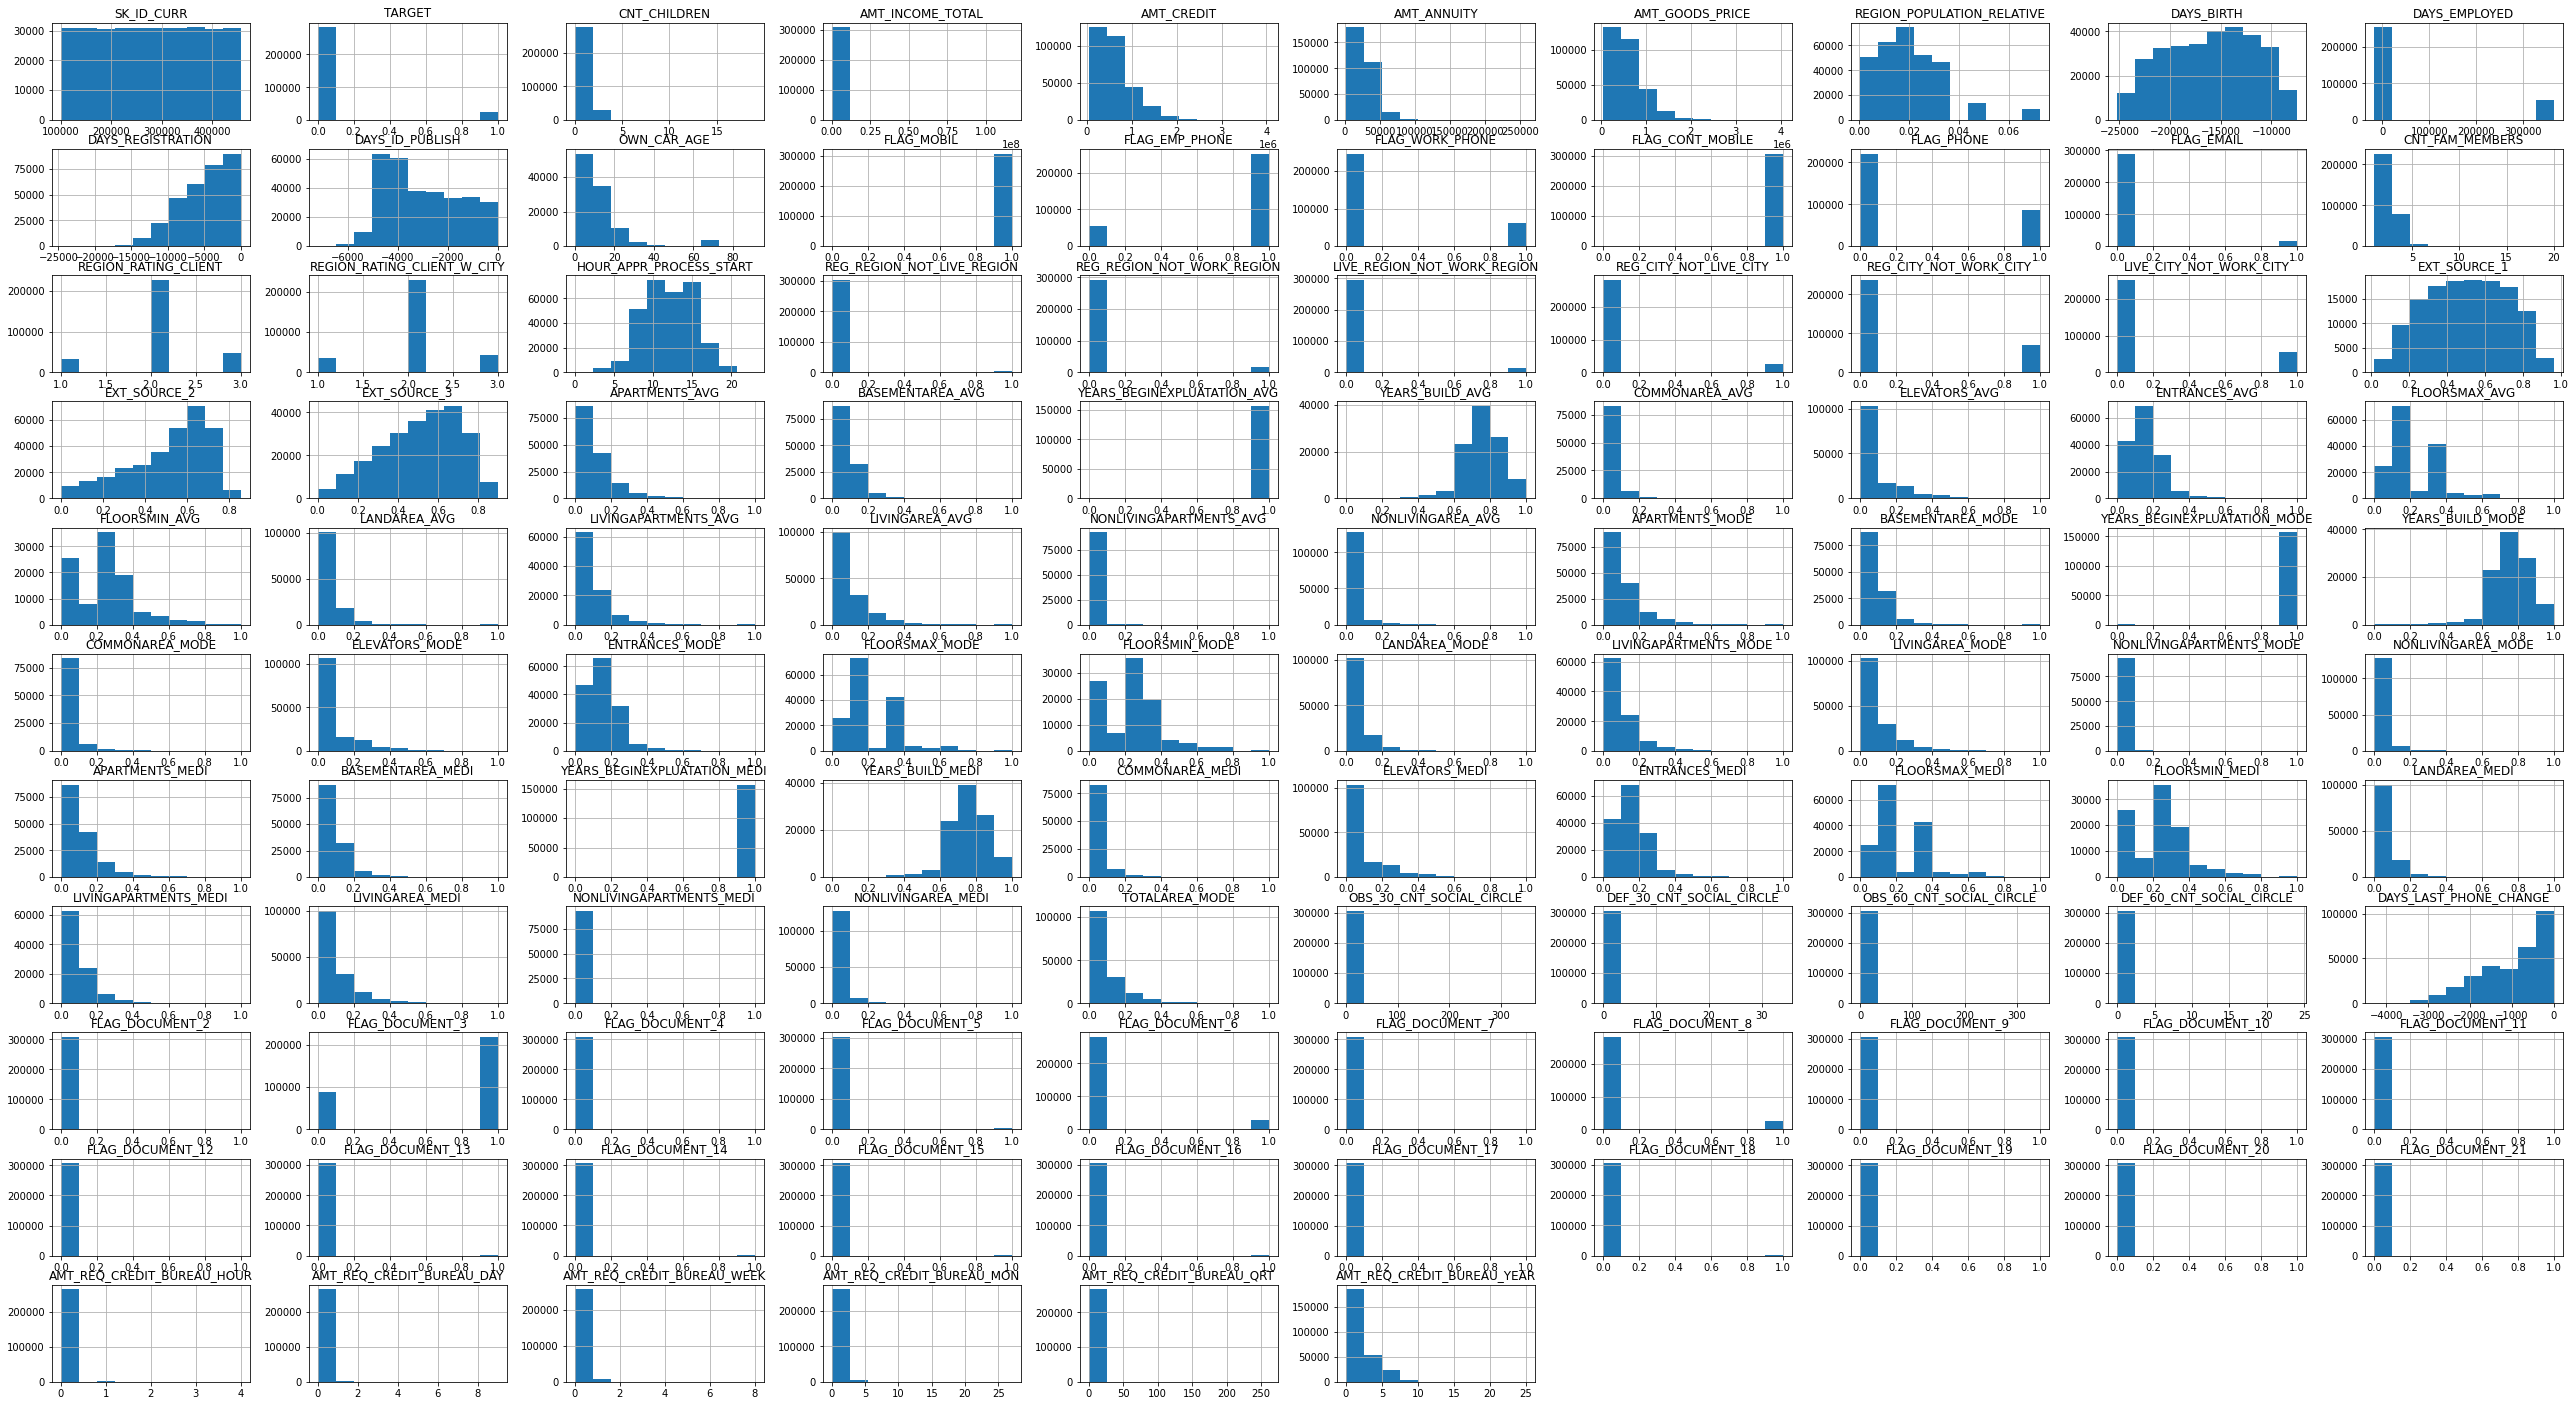

In [13]:
train.hist(figsize=(45,25))

In [14]:
train.isna().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

Наблюдается дисбаланс классов

In [14]:
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [16]:
train.TARGET.mean()

0.08072881945686496

In [17]:
X = train.drop(['TARGET'], axis=1)
y = train['TARGET']

Изучим категориальные переменные

In [16]:
cat_cols = list(train.select_dtypes(include=['object']).columns)

In [17]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [20]:
for cat in cat_cols:
    print(train[[cat, 'TARGET']].groupby([cat], as_index=False).mean())    

  NAME_CONTRACT_TYPE    TARGET
0         Cash loans  0.083459
1    Revolving loans  0.054783
  CODE_GENDER    TARGET
0           F  0.069993
1           M  0.101419
2         XNA  0.000000
  FLAG_OWN_CAR    TARGET
0            N  0.085002
1            Y  0.072437
  FLAG_OWN_REALTY    TARGET
0               N  0.083249
1               Y  0.079616
   NAME_TYPE_SUITE    TARGET
0         Children  0.073768
1           Family  0.074946
2  Group of people  0.084871
3          Other_A  0.087760
4          Other_B  0.098305
5  Spouse, partner  0.078716
6    Unaccompanied  0.081830
       NAME_INCOME_TYPE    TARGET
0           Businessman  0.000000
1  Commercial associate  0.074843
2       Maternity leave  0.400000
3             Pensioner  0.053864
4         State servant  0.057550
5               Student  0.000000
6            Unemployed  0.363636
7               Working  0.095885
             NAME_EDUCATION_TYPE    TARGET
0                Academic degree  0.018293
1               Higher educa

In [18]:
num_cols = list(train.select_dtypes(include=['int64', 'float64']).columns)

In [19]:
num_cols

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

Изучим количественные признаки, может там есть еще категориальные

In [23]:
train[num_cols].loc[:, train.nunique() < 15]

,TARGET,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT
0,1,1,1,0,1,1,0,2,2,0,0,0,0,0,0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,1,0,2,2,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0,1,1,0,1,0,0,2,2,0,0,0,0,0,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,0,1,1,0,1,0,0,2,2,0,0,0,0,1,1,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
307507,0,1,0,0,1,1,0,2,2,0,0,0,0,0,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
307508,0,1,1,0,1,0,1,3,3,0,0,0,0,1,1,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0
307509,1,1,1,0,1,0,0,2,2,0,0,0,1,1,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [24]:
binary_cols = list(train[num_cols].loc[:, train.nunique() < 15].columns)

In [25]:
binary_cols.remove('TARGET')

In [26]:
binary_cols

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_QRT']

In [27]:
for binary in binary_cols:
    print(train[[binary, 'TARGET']].groupby([binary], as_index=False).mean())   

   FLAG_MOBIL    TARGET
0           0  0.000000
1           1  0.080729
   FLAG_EMP_PHONE    TARGET
0               0  0.054003
1               1  0.086600
   FLAG_WORK_PHONE    TARGET
0                0  0.076851
1                1  0.096301
   FLAG_CONT_MOBILE    TARGET
0                 0  0.078397
1                 1  0.080733
   FLAG_PHONE    TARGET
0           0  0.084784
1           1  0.070357
   FLAG_EMAIL    TARGET
0           0  0.080846
1           1  0.078775
   REGION_RATING_CLIENT    TARGET
0                     1  0.048203
1                     2  0.078891
2                     3  0.111028
   REGION_RATING_CLIENT_W_CITY    TARGET
0                            1  0.048409
1                            2  0.079178
2                            3  0.114022
   REG_REGION_NOT_LIVE_REGION    TARGET
0                           0  0.080540
1                           1  0.092978
   REG_REGION_NOT_WORK_REGION    TARGET
0                           0  0.080291
1                      

In [28]:
cor = X.corrwith(y)
cor[abs(cor) > 0.1]

EXT_SOURCE_1   -0.155317
EXT_SOURCE_2   -0.160472
EXT_SOURCE_3   -0.178919
dtype: float64

In [29]:
null_count = pd.DataFrame(train.isnull().sum())
null_count = null_count[null_count[0] > len(train) * 0.6]
null_count

,0
OWN_CAR_AGE,202929
YEARS_BUILD_AVG,204488
COMMONAREA_AVG,214865
FLOORSMIN_AVG,208642
LIVINGAPARTMENTS_AVG,210199
NONLIVINGAPARTMENTS_AVG,213514
YEARS_BUILD_MODE,204488
COMMONAREA_MODE,214865
FLOORSMIN_MODE,208642
LIVINGAPARTMENTS_MODE,210199


In [30]:
WOE_encoder = ce.WOEEncoder()
train_woe = WOE_encoder.fit_transform(train[cat_cols], y)
test_woe = WOE_encoder.transform(test[cat_cols])

C:\Python\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [31]:
test_woe

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0.036202,-0.154315,0.056221,-0.015113,0.014724,0.188660,-0.439432,-0.071234,-0.037978,-0.231453,0.036963,-0.147023,0.071374,-0.162918,-0.093375,-0.159598
1,0.036202,0.250941,0.056221,-0.015113,0.014724,0.188660,0.111466,-0.071234,-0.037978,0.859753,0.010085,0.254589,0.071374,0.137162,0.134385,0.150273
2,0.036202,0.250941,-0.117305,-0.015113,-0.413970,0.188660,-0.439432,-0.071234,-0.037978,0.374973,-0.043154,0.760099,0.071374,0.137162,0.134385,0.150273
3,0.036202,-0.154315,0.056221,-0.015113,0.014724,0.188660,0.111466,-0.071234,-0.037978,0.193878,0.011871,0.154966,-0.157452,-0.162918,-0.258867,-0.159598
4,0.036202,0.250941,-0.117305,0.033532,0.014724,0.188660,0.111466,-0.071234,-0.037978,-0.231453,0.010085,0.154966,0.071374,0.137162,0.134385,0.150273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.036202,-0.154315,0.056221,-0.015113,0.014724,0.188660,0.111466,-0.349726,-0.037978,-0.231453,0.011871,-0.058810,0.071374,0.137162,0.134385,0.150273
48740,0.036202,-0.154315,0.056221,0.033532,0.014724,-0.081994,0.111466,-0.071234,-0.037978,0.193878,-0.043154,0.173690,0.071374,0.137162,0.134385,0.150273
48741,0.036202,-0.154315,-0.117305,-0.015113,0.014724,-0.081994,0.111466,-0.071234,-0.037978,-0.231453,0.011871,0.154966,0.071374,-0.162918,-0.093375,-0.159598
48742,0.036202,0.250941,0.056221,0.033532,-0.080369,-0.081994,-0.439432,-0.071234,-0.037978,-0.281091,-0.043154,0.254589,0.071374,-0.162918,-0.258867,-0.159598


In [51]:
q = train["OWN_CAR_AGE"].fillna(-0)

In [45]:
train["OWN_CAR_AGE"].unique()

array([nan, 26., 17.,  8., 23.,  7., 14.,  1.,  3., 13., 10.,  2., 21.,
       20., 22., 65.,  5., 11.,  9.,  4., 15., 12., 25.,  6., 64.,  0.,
       27., 19., 28., 18., 16., 30., 36., 24., 39., 29., 40., 41., 31.,
       42., 37., 35., 34., 33., 54., 38., 32., 43., 55., 49., 44., 63.,
       46., 45., 48., 56., 51., 57., 69., 50., 47., 91., 52.])

In [46]:
q

0         (-0.091, 22.75]
1         (-0.091, 22.75]
2           (22.75, 45.5]
3         (-0.091, 22.75]
4         (-0.091, 22.75]
               ...       
307506    (-0.091, 22.75]
307507    (-0.091, 22.75]
307508    (-0.091, 22.75]
307509    (-0.091, 22.75]
307510    (-0.091, 22.75]
Name: OWN_CAR_AGE, Length: 307511, dtype: category
Categories (4, interval[float64, right]): [(-0.091, 22.75] < (22.75, 45.5] < (45.5, 68.25] < (68.25, 91.0]]

In [94]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,3,0.036202,0.250941,0.056221,-0.015113,0,0,0,0.0,0.0,0.014724,0.188660,0.111466,0.213833,-0.037978,1,3,0,3,2,NaN,3,3,0,3,3,0,0.298054,0.0,1,1,0.011871,1,0,0,0,0,0,0,0.154966,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.157452,-0.162918,0.0,-0.093375,-0.159598,0.0,0.0,0.0,0.0,2.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.036202,-0.154315,0.056221,0.033532,0,0,1,0.0,1.0,-0.080369,-0.362672,-0.439432,-0.071234,-0.037978,0,1,0,3,3,NaN,3,3,0,3,3,0,-0.265930,0.0,0,0,-0.043154,1,0,0,0,0,0,0,-0.332558,1.0,2.0,NaN,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.157452,-0.162918,0.0,-0.149061,-0.159598,0.0,0.0,0.0,0.0,3.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,-0.415030,0.250941,-0.117305,-0.015113,0,0,0,0.0,0.0,0.014724,0.188660,0.111466,0.213833,-0.037978,0,1,0,3,2,1.0,3,3,3,3,3,0,0.298054,0.0,1,1,-0.043154,1,0,0,0,0,0,0,-0.156375,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071374,0.137162,NaN,0.134385,0.150273,0.0,0.0,0.0,0.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.036202,-0.154315,0.056221,-0.015113,0,0,0,0.0,0.0,0.014724,0.188660,0.111466,0.229315,-0.037978,0,1,0,2,2,NaN,3,3,0,3,0,0,0.298054,0.0,1,1,0.011871,2,0,0,0,0,0,0,0.154966,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [20]:
num_cols.remove('TARGET')

In [39]:
def preprocessing(train, test):
#     WOE_encoder = ce.WOEEncoder()
#     train[cat_cols] = WOE_encoder.fit_transform(train[cat_cols], train['TARGET'])
#     test[cat_cols] = WOE_encoder.transform(test[cat_cols])
    train = train.fillna(-10)
    test = test.fillna(-10)

    train[num_cols] = train[num_cols].apply(lambda x: pd.cut(x, bins=4, labels=False))
    test[num_cols] = test[num_cols].apply(lambda x: pd.cut(x, bins=4, labels=False))

    return train, test  

In [40]:
train_norm, test_norm = preprocessing(train, test)

In [117]:
train_norm['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [23]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [24]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('bbc', BalancedBaggingClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # level0.append(('lama', automl))
    level0.append(('lgbm', lgbm_clf))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
random_state=42

fit_params = {"early_stopping_rounds" : 100,
              "eval_metric" : 'auc',
              "eval_set" : [(X,y)],
              'eval_names': ['valid'],
              'verbose': 0,
              'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50),
              'min_child_samples': sp_randint(100, 500),
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8),
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 30
#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=False, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test,
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

In [25]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['bbc'] = BalancedBaggingClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    # models['lama'] = automl
    models['lgb'] = lgbm_clf
    return models

In [74]:
def compare_models(X_res, y_res):
    # get the models to evaluate
    models = get_models()
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X_res, y_res)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    # plot model performance for comparison
    figure(figsize=(10, 5), dpi=80)   
    pyplot.ylabel('Средний f-score', fontsize=18)
    pyplot.boxplot(results, labels=names, showmeans=True, widths=0.5)
    pyplot.show()

In [32]:
def get_submission(prediction, name):
  write_submission = pd.read_csv('data/sample_submission.csv')
  write_submission['TARGET'] = prediction
  write_submission.to_csv(f'prediction.csv', index= False)

In [108]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [41]:
X_train = train_norm.drop('TARGET', axis=1)
y_train = train_norm['TARGET']
X_test = test_norm

In [ ]:
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X_train, y_train)

In [ ]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
predict_2 = svc.predict(X_test)

In [ ]:
write_submission_2 = pd.read_csv('data/sample_submission.csv')
write_submission_2['TARGET'] = predict_2
write_submission_2.to_csv('predict_2.csv', index= False)

In [44]:

LR_model_2 = LogisticRegression()

LR_model_2.fit(X_train[num_cols], y_train)
predict_2 = LR_model_2.predict(X_test[num_cols])

C:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
get_submission(predict_2, 'lr_nums')

In [48]:
!kaggle competitions submit -c home-credit-default-risk -f prediction.csv -m "Message"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/476k [00:00<?, ?B/s]
  2%|1         | 8.00k/476k [00:00<00:15, 30.4kB/s]
 20%|##        | 96.0k/476k [00:00<00:01, 254kB/s] 
 27%|##6       | 128k/476k [00:00<00:01, 258kB/s] 
 81%|########  | 384k/476k [00:00<00:00, 895kB/s]
100%|##########| 476k/476k [00:03<00:00, 147kB/s]


In [35]:
def get_kaggle_results():
    p = subprocess.Popen("kaggle competitions submissions  -c home-credit-default-risk", stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    print(output.decode())

In [49]:
get_kaggle_results()

fileName                          date                 description  status    publicScore  privateScore  
--------------------------------  -------------------  -----------  --------  -----------  ------------  
prediction.csv                    2021-12-02 11:58:38  Message      complete  0.50000      0.50000       
predict_sample_lr_cat.csv         2021-12-02 11:54:58  None         complete  0.50000      0.50000       
predict_sample_lr_old.csv         2021-12-02 11:52:09  None         complete  0.50000      0.50000       
prediction.csv                    2021-12-02 11:37:42  Message      complete  0.50000      0.50000       
predict_sample_lr_qcat2.csv       2021-12-02 11:31:23  None         complete  0.50000      0.50000       
predict_2 (1).csv                 2021-12-02 11:10:31  None         complete  0.59257      0.58064       
predict_sample_lr_qcat.csv        2021-12-02 11:09:24  None         complete  0.50000      0.50000       
predict_samplelr_qcat.csv         2021-12-02 1

In [ ]:
compare_models(X, y)